In [ ]:
# I had a problem (kernel crash) when running the umap with my computer with numba, python and the kernel so I have to restart the kernel and run this peace of code
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"


In [ ]:
# Requirements: git clone the midaa repo
import pickle
import torch
import scipy

import midaa as maa
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from python_tsp.exact import solve_tsp_dynamic_programming

/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I) Vizualization of the data

In [ ]:
adata = sc.read_h5ad("data/9NewsGroups_annData_Normalized.h5ad")

adata

AnnData object with n_obs × n_vars = 11314 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

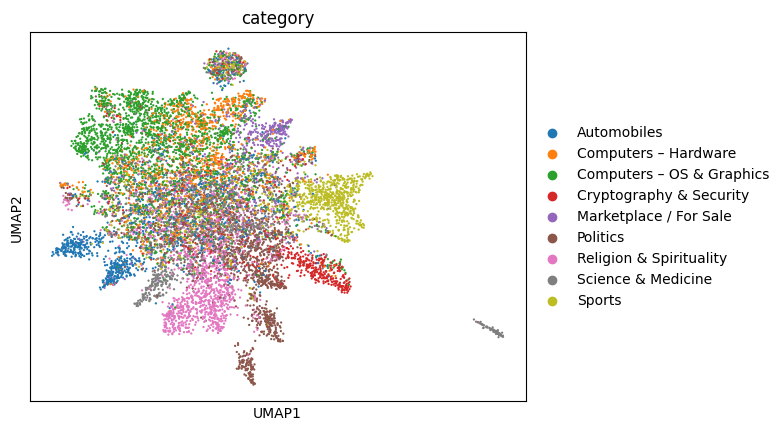

In [23]:
sc.pl.umap(adata, color="category")

# II) Choose number of steps

DAARIO has the following architecture:
- One encoder by modality (hidden_dims_enc_ind)
- One common encoder (hidden_dims_enc_common)
- Final layer that maps to the latent space 𝑍 (hidden_dims_enc_pre_Z)
- One decoder by modality (hidden_dims_dec_common)
- One common decoder (hidden_dims_dec_common)


In [24]:
input_distribution = ["G"] # Gaussian because normalized data

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch

# Ensure reproducibility
np.random.seed(42)
y = adata.obs["category"].values

train_idx, test_idx = train_test_split(
    np.arange(adata.n_obs),
    test_size=0.20,
    shuffle=True,
    random_state=42,
    stratify=y # Startisfy by category
)

# Train/Test AnnData datasets
adata_train = adata[train_idx].copy()
adata_test  = adata[test_idx].copy()

# Prepare MIDAA input format (one modality)
train_set = [adata_train.X]
normalization_train = [np.ones(adata_train.X.shape[0])]

test_set = [torch.tensor(adata_test.X.toarray() 
                         if hasattr(adata_test.X, "toarray") 
                         else adata_test.X, dtype=torch.float32)]
normalization_test = [np.ones(adata_test.X.shape[0])]


In [8]:
adata_train

AnnData object with n_obs × n_vars = 9051 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
adata

AnnData object with n_obs × n_vars = 11314 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
adata_test

AnnData object with n_obs × n_vars = 2263 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
def evaluate_model_loss(
    model_obj,
    input_matrix,
    norm_factors,
    input_matrix_side=None,
    model_matrix=None,
    loss_weights_reconstruction=None,
    loss_weights_side=None,
    batch_size=5120,
):
    """
    Evaluate the MIDAA model on a dataset WITHOUT training.
    Uses model_obj.model(...) directly and returns per-batch and mean loss.
    This is essentially an approximation to -ELBO (negative ELBO).
    """

    model_obj.eval()

    # Get device from the model (CPU or CUDA)
    device = next(model_obj.parameters()).device

    # Input tensor has to be a tensor array, and ensure that it is on device
    tensors_inputs = []
    for x in input_matrix:
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32, device=device)
        else:
            x = x.to(device)
        tensors_inputs.append(x)

    # Same for the normalization factors
    tensors_norms = []
    for nf in norm_factors:
        if isinstance(nf, np.ndarray):
            nf = torch.tensor(nf, dtype=torch.float32, device=device)
        else:
            nf = nf.to(device)
        tensors_norms.append(nf)

    n_samples = tensors_inputs[0].shape[0]

    batch_losses = []

    with torch.no_grad():
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)

            batch_inputs = [x[start:end] for x in tensors_inputs]
            batch_norms  = [n[start:end] for n in tensors_norms]

            # Call the probabilistic model (pyro)
            out = model_obj.model(
                input_matrix=batch_inputs,
                model_matrix=model_matrix,
                norm_factors=batch_norms,
                input_matrix_side=input_matrix_side,
                loss_weights_reconstruction=loss_weights_reconstruction,
                loss_weights_side=loss_weights_side,
                initialization_input=None,
                initialization_B_weight=None,
            )

            total_loss = out[-1]  # last element is total_loss
            batch_losses.append(total_loss.item())

    mean_loss = float(np.mean(batch_losses))
    return -mean_loss



=== Training architecture (scale = 1200) ===


ELBO: 26389726.00000  : 100%|██████████| 1200/1200 [15:51<00:00,  1.26it/s]
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(



=== Training architecture (scale = 1300) ===


ELBO: 26366380.00000  : 100%|██████████| 1300/1300 [17:54<00:00,  1.21it/s]


ValueError: x and y must be the same size

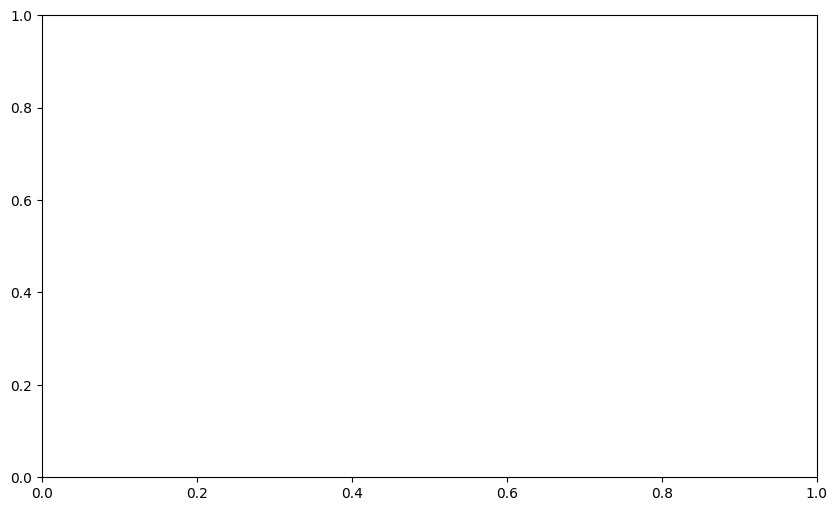

In [44]:
num_steps = [200, 500, 800, 1100, 1200, 1300, 1400, 1700] # We have discovered that around 1200, the overfitting happened so we put higher granularity of results around the point
train_elbos = []
test_losses = []

for n in num_steps:
    print(f"\n=== Training architecture (scale = {n}) ===")

    # Train model
    res_train = maa.fit_MIDAA(
        input_matrix=train_set,
        normalization_factor=normalization_train,
        input_types=input_distribution,
        lr=0.001,
        steps=n,
        narchetypes=5,
    )

    train_elbo = res_train["ELBO"]

    # Evaluate TEST set
    res_test = evaluate_model_loss(
        model_obj=res_train["deepAA_obj"],
        input_matrix=test_set,
        norm_factors=normalization_test,
        input_matrix_side=None,
        model_matrix=None,
        loss_weights_reconstruction=None,
        loss_weights_side=None,
        batch_size=5120
    )

    test_loss = res_test

    train_elbos.append(train_elbo[-1])
    test_losses.append(test_loss)


NameError: name 'num_steps' is not defined

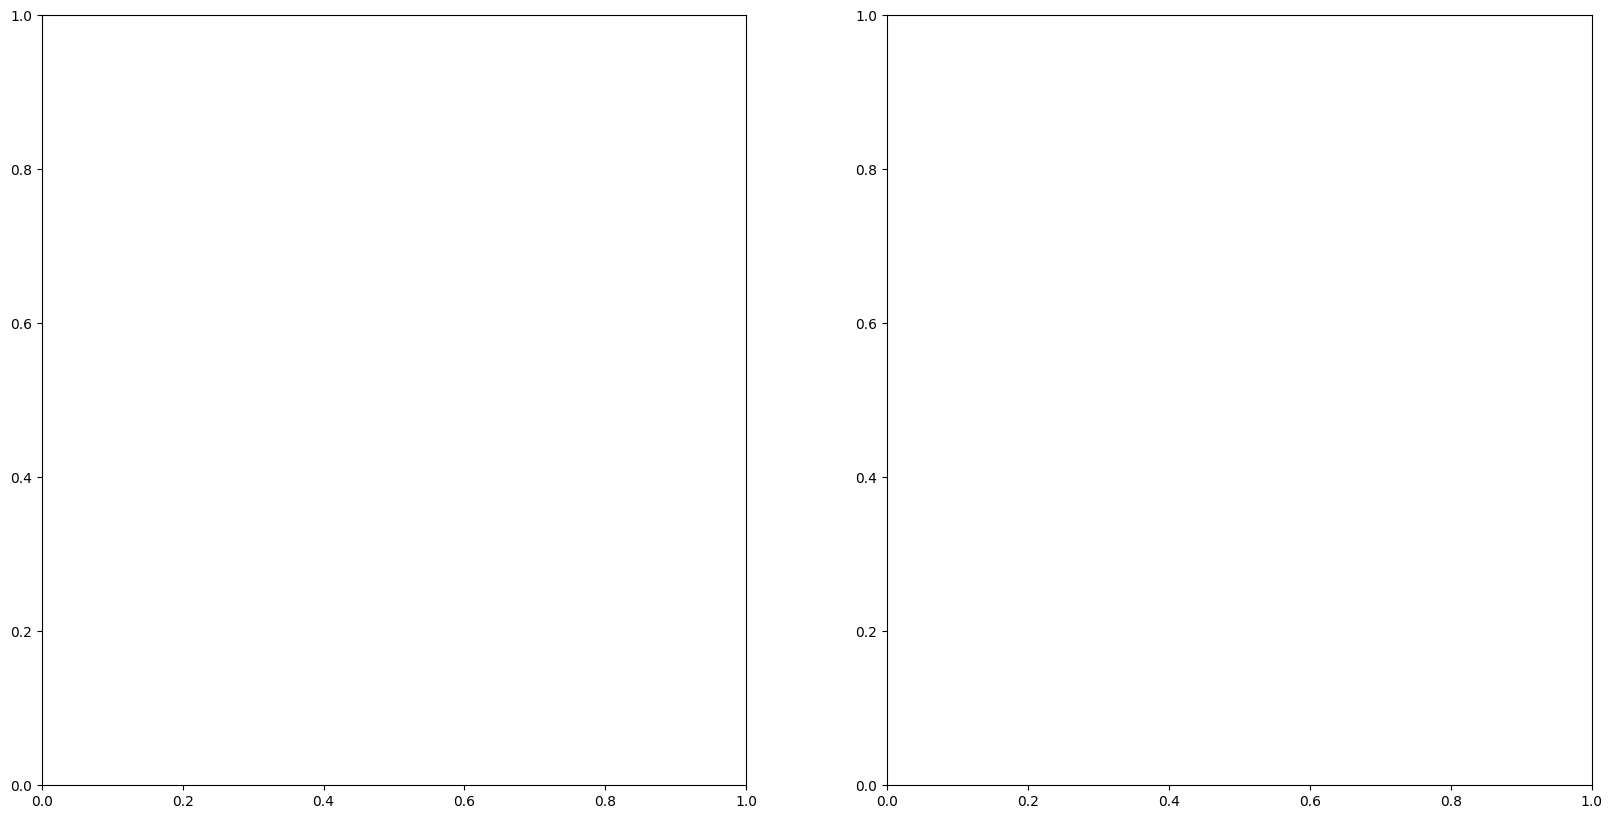

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

axes[0].scatter(num_steps , train_elbos, label="train")
axes[0].set_yscale("log") # Log y-axis for better visualization due to high variance on results
axes[0].set_title("train ELBO curve in function of training steps (log scale)")

axes[1].scatter(num_steps, test_losses)
axes[1].set_yscale("log")
axes[1].set_title("test loss curve in function of training steps (log scale)")

plt.legend()
plt.grid()
plt.show()

Conclusion: Overfitting start at 1200 steps, To ensure not overfitting we retain 1100 steps

# III) Choose number of archetypes: Elbow Methods

## 1) Start the training

In [15]:
models = {}

for i in tqdm(range(2, 4)): # Between 4 and 7 archetypes 
    model = maa.fit_MIDAA(train_set,
    normalization_train,
    input_distribution,
    lr=0.001,
    steps=1100, # result from previous study
    narchetypes=i)

    models[i]=model
    

    deepAA = model["deepAA_obj"]
    model_to_save = {
        "inferred_quantities": model["inferred_quantities"],
        "hyperparameters": model["hyperparameters"],
        "ELBO": model["ELBO"]
    }

    with open(f"model_save/model_{i}_metadata.pkl", "wb") as f:
        pickle.dump(model_to_save, f)

    torch.save(deepAA.state_dict(), f"model_save/model_{i}_weights.pt")

ELBO: 26495182.00000  : 100%|██████████| 1100/1100 [17:25<00:00,  1.05it/s]
/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
100%|██████████| 2/2 [35:26<00:00, 1063.31s/it]


## 2) Reproduce the results downloading the results

In [3]:
models = {}

for i in range(2, 8):
    model = {}
    with open(f"model_save/single_input/model_{i}_metadata.pkl", "rb") as f:
        model=pickle.load(f)

    model["deepAA_obj"] = torch.load(f"model_save/single_input/model_{i}_weights.pt")
    models[i]=model

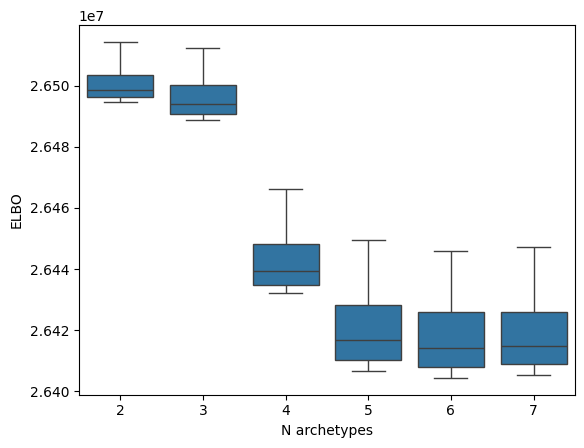

In [ ]:
maa.plot_ELBO_across_runs(models, warmup=500) # We pick the last 500 steps of the training

Conclusion of the ELBOW: 4 archetypes.

# IV) Metric to assess the model


Between DAA:  

⁠Reconstruction error :
- MSE between reconstructed input and input

Between Linear AA and DAA:  
- Nearest archetype classification accuracy: Accuracy of classification through the confusion matrix of each model (classify a point as the nearest archetype after reconstruction)

In [2]:
model = maa.fit_MIDAA(train_set,
    normalization_train,
    input_distribution,
    lr=0.001,
    steps=1100, # result from previous study
    narchetypes=3) # result from previous study

model

NameError: name 'maa' is not defined

In [ ]:
model = {}
with open("model_save/single_input/model_4_metadata.pkl", "rb") as f:
        model=pickle.load(f)

model["deepAA_obj"] = torch.load("model_save/single_input/model_4_weights.pt")

## 1) ELBO between reconstructed input and input

In [8]:
model["ELBO"][-1]

array(26432244., dtype=float32)

# V) Vizualization
- ⁠Plot to vizualize the Archetypes in the UMAP plot
- ⁠⁠Convex hull plot


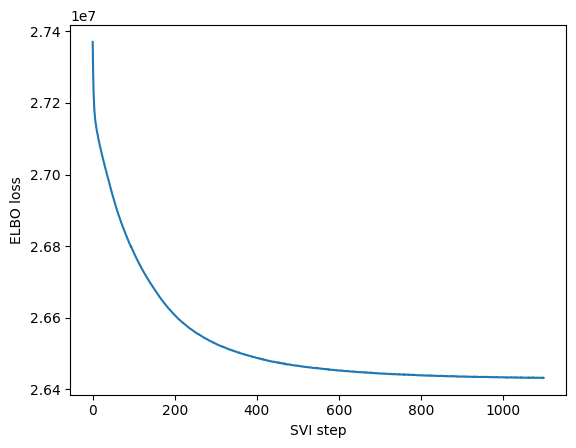

In [39]:
maa.plot_ELBO(model)

(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

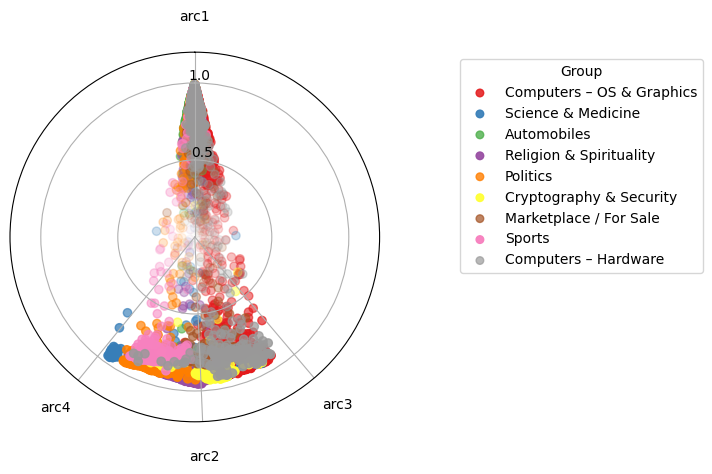

In [16]:
maa.plot_archetypes_simplex(model, color_by=adata_train.obs['category'], cmap='Set1')

(<Figure size 1500x1500 with 9 Axes>,
 array([<PolarAxes: title={'center': 'Group: Computers – OS & Graphics'}>,
        <PolarAxes: title={'center': 'Group: Science & Medicine'}>,
        <PolarAxes: title={'center': 'Group: Automobiles'}>,
        <PolarAxes: title={'center': 'Group: Religion & Spirituality'}>,
        <PolarAxes: title={'center': 'Group: Politics'}>,
        <PolarAxes: title={'center': 'Group: Cryptography & Security'}>,
        <PolarAxes: title={'center': 'Group: Marketplace / For Sale'}>,
        <PolarAxes: title={'center': 'Group: Sports'}>,
        <PolarAxes: title={'center': 'Group: Computers – Hardware'}>],
       dtype=object))

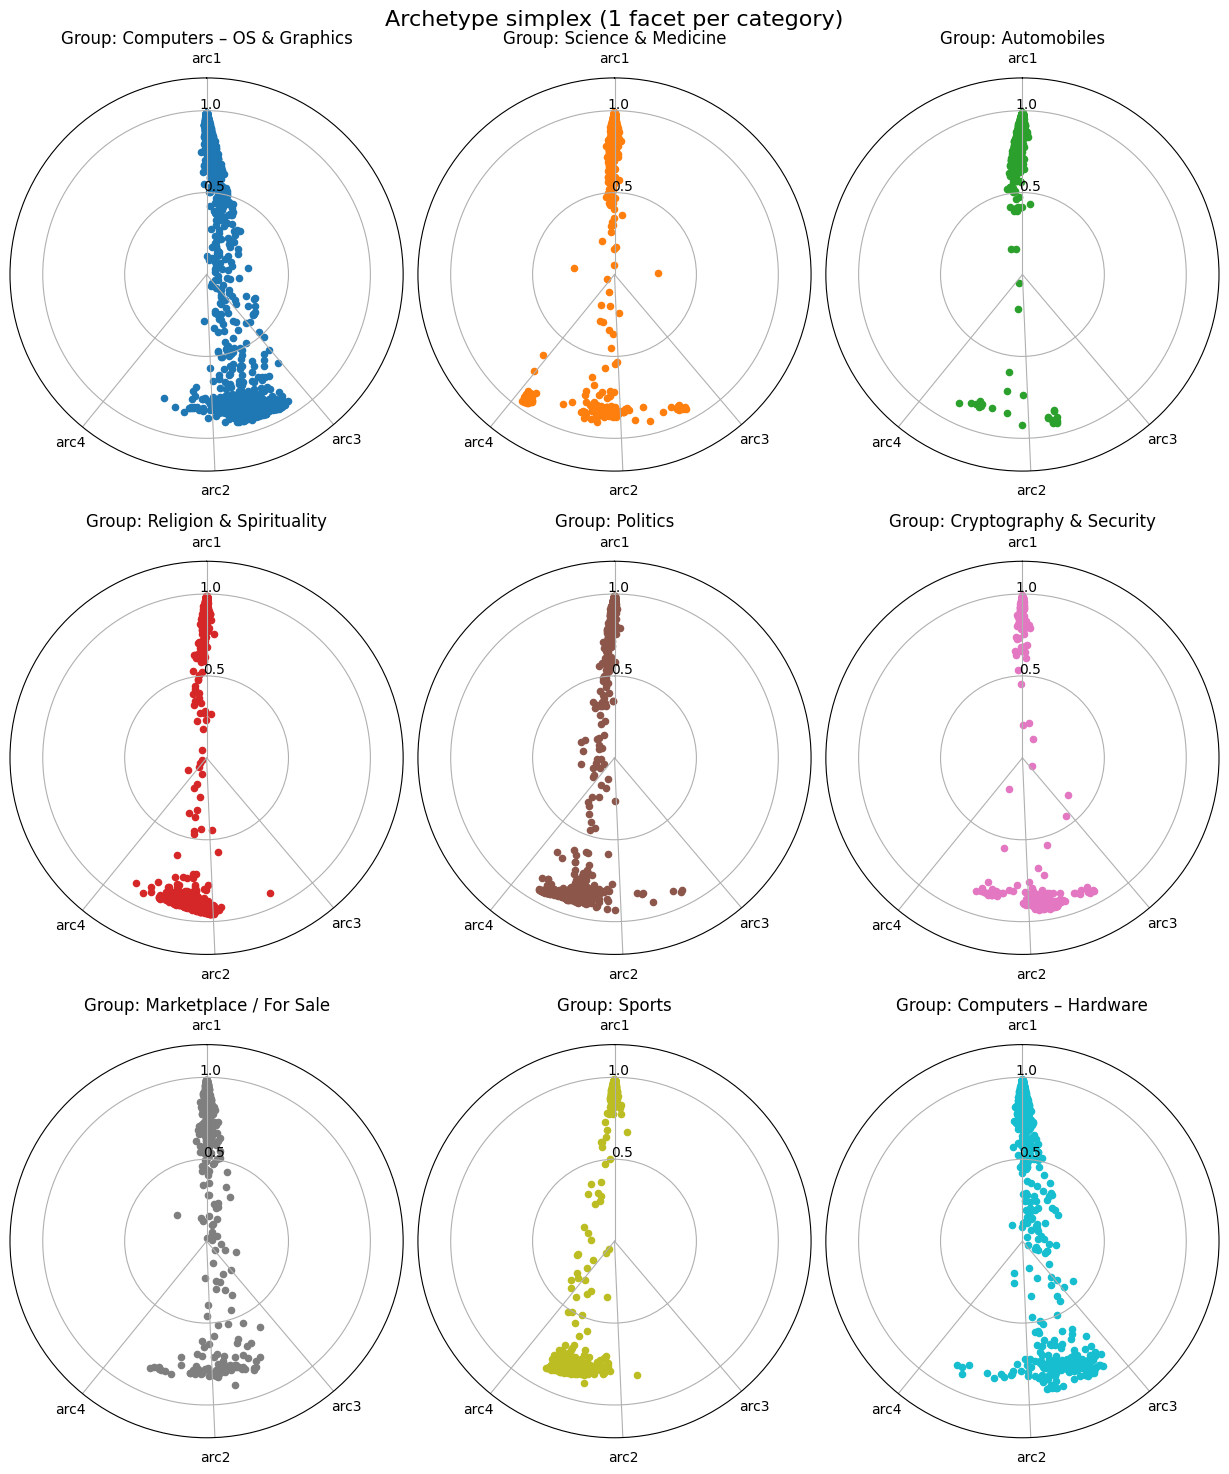

In [ ]:
def plot_archetypes_simplex_facets(
    res,
    distance_type="euclidean",
    cmap="nipy_spectral",
    color_by=None,
    subsample=None,
    s=20,
    figsize=(15, 15),
    l_title="Group"
):
    """
    Plot the data in the latent space in a 2d simplex
    """

    # 1) Compute the geometry (theta, r)
    if subsample is not None:
        arcs = res["inferred_quantities"]["A"][subsample, :]
    else:
        arcs = res["inferred_quantities"]["A"]

    dist_matrix = scipy.spatial.distance.cdist(arcs.T, arcs.T, distance_type)
    permutation, distance = solve_tsp_dynamic_programming(dist_matrix)

    dists = []
    for i in range(1, len(permutation)):
        dists.append(dist_matrix[permutation[i - 1], permutation[i]])
    dists.append(dist_matrix[permutation[-1], permutation[0]])
    dists = np.array(dists)
    dists /= dists.sum()

    labels = 360 * dists
    labels = labels.cumsum()[:-1]
    labels = np.append(0, labels)
    labels_rad = np.radians(labels)

    A = res["inferred_quantities"]["A"][:, permutation]

    r = np.sqrt((A * np.cos(labels_rad)).sum(axis=1)**2 +
                (A * np.sin(labels_rad)).sum(axis=1)**2)
    theta = np.arctan2(
        (A * np.sin(labels_rad)).sum(axis=1),
        (A * np.cos(labels_rad)).sum(axis=1)
    )

    arc_names = [f"arc{i+1}" for i in permutation]


    if color_by is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='polar')
        ax.scatter(theta, r, color="steelblue", s=s)  # FIX: uniform color
        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.grid(True)
        return fig, ax

    # 3) Multi-subplot: 1 plot per category
    unique_vals = list(color_by.unique())
    n = len(unique_vals)

    fig, axes = plt.subplots(
        3, 3,
        figsize=(figsize[0], figsize[1]),
        subplot_kw={"projection": "polar"}
    )
    axes = axes.flatten()

    # Define a palette: one color per category
    palette = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
    color_map = {val: palette[i] for i, val in enumerate(unique_vals)}

    for ax, val in zip(axes, unique_vals):

        idx = color_by == val

        ax.scatter(theta[idx], r[idx], color=color_map[val], s=s)

        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.set_rticks([0.5, 1])
        ax.set_rlabel_position(-2.5)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.grid(True)

        ax.set_title(f"{l_title}: {val}")

    fig.suptitle("Archetype simplex (1 facet per category)", fontsize=16)
    fig.subplots_adjust(top=0.2)
    plt.tight_layout()

    return fig, axes


plot_archetypes_simplex_facets(model, color_by=adata_train.obs['category'])

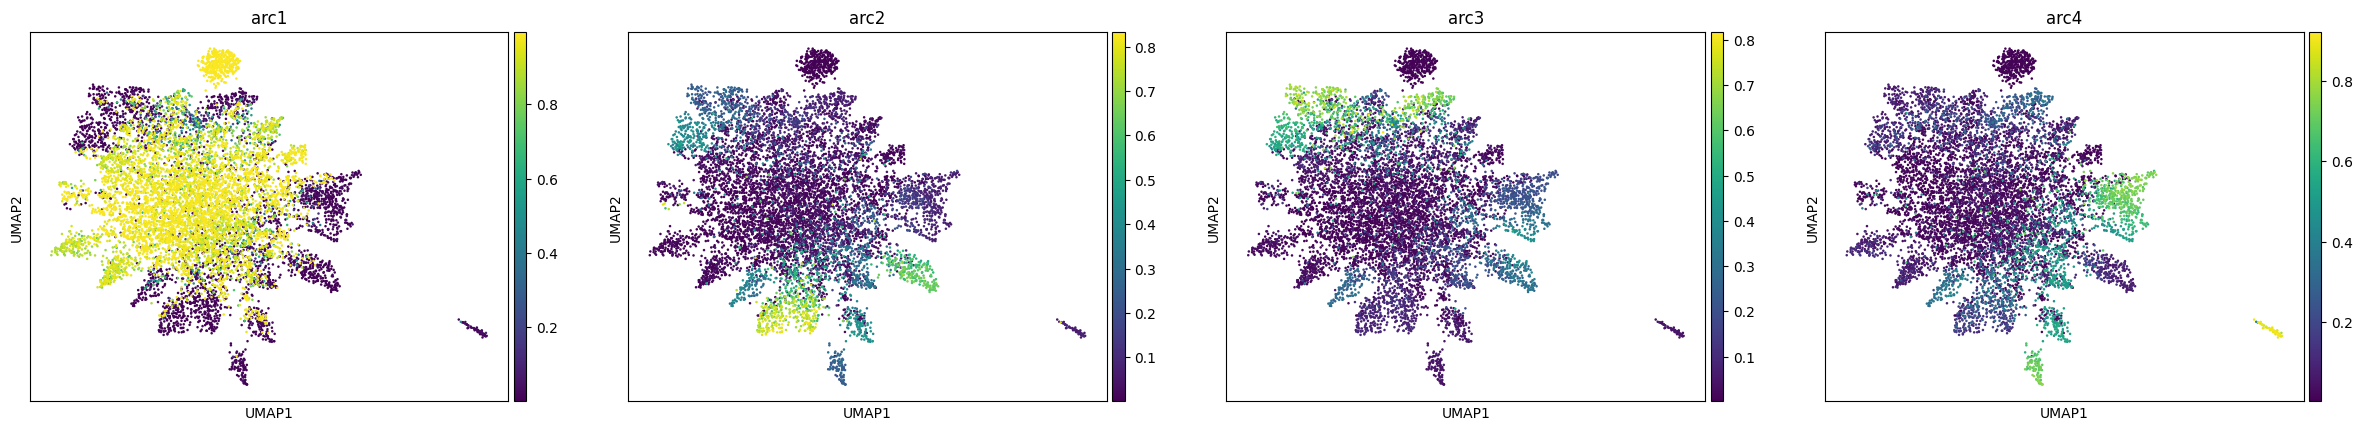

In [17]:
adata_train, arc_names = maa.add_to_obs_adata(model, adata_train)
sc.pl.umap(adata_train, color = arc_names)


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


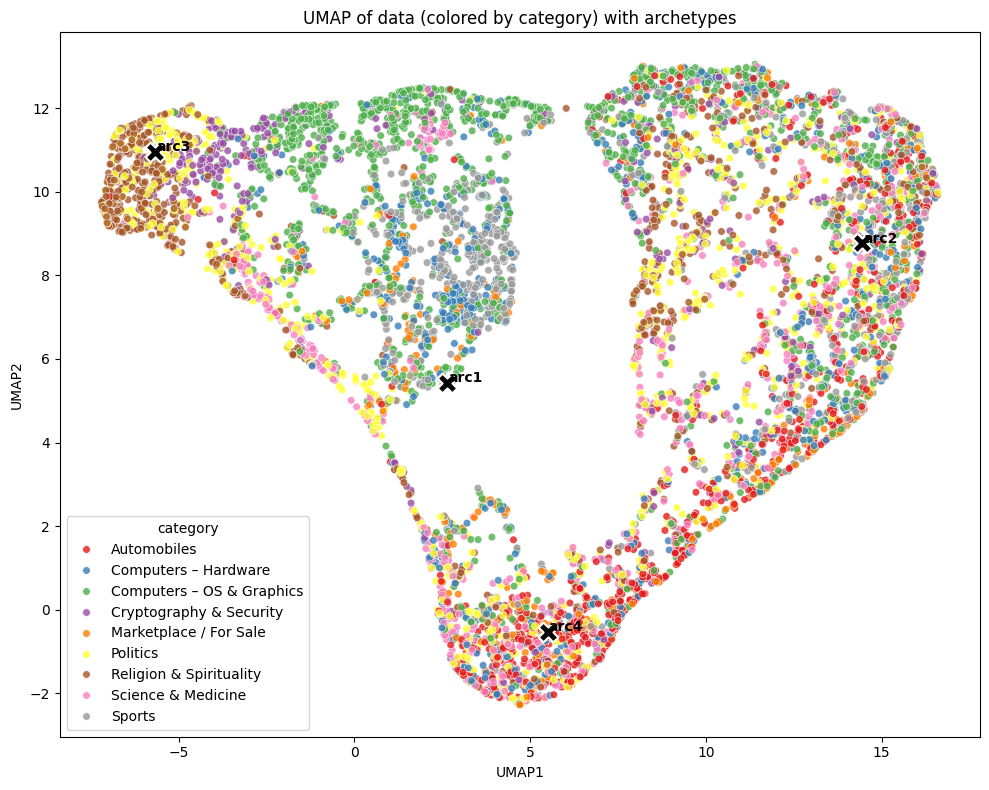

In [ ]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap_data_and_archetypes(model, categories, palette="Set1",
                                  n_neighbors=15, min_dist=0.1, metric="euclidean"):
    """
    2D UMAP of the latent space   
    """
    # Get data and archetypes in the feature space 
    Z = model["inferred_quantities"]["Z"]                    # (N, d)
    A = model["inferred_quantities"]["archetypes_inferred"]  # (K, d)

    N = Z.shape[0]
    K = A.shape[0]

    X_all = np.vstack([Z, A])  

    # UMAP 2d
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]  
    A_umap = emb_all[N:]       

    df = pd.DataFrame({
        "UMAP1": Z_umap[:, 0],
        "UMAP2": Z_umap[:, 1],
        "category": categories.values
    })

    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df,
        x="UMAP1",
        y="UMAP2",
        hue="category",
        palette=palette,
        alpha=0.8,
        s=30,
    )

    # Overlay archetypes
    sns.scatterplot(
        x=A_umap[:, 0],
        y=A_umap[:, 1],
        s=200,
        marker="X",
        color="black",
        edgecolor="white",
        linewidth=1.5,
        ax=ax,
        legend=False,
    )

    # Label archetypes
    for i, (x, y) in enumerate(A_umap):
        plt.text(x + 0.02, y + 0.02, f"arc{i+1}", fontsize=10, weight="bold")

    plt.title("UMAP of data (colored by category) with archetypes")
    plt.tight_layout()
    return ax

ax = plot_umap_data_and_archetypes(
    model,
    categories=adata_train.obs["category"],
    palette="Set1"
)

In [ ]:
def plot_umap3d_data_and_archetypes(
    model,
    categories,
    palette="Set1",
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    figsize=(10, 8)
):
    """
    3D UMAP of the latent space   
    """

    Z = model["inferred_quantities"]["Z"]
    A = model["inferred_quantities"]["archetypes_inferred"]

    N = Z.shape[0]
    K = A.shape[0]

    X_all = np.vstack([Z, A])

    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]
    A_umap = emb_all[N:]

    import seaborn as sns

    cats = pd.Series(categories).reset_index(drop=True)
    unique_cats = cats.unique()
    pal = sns.color_palette(palette, len(unique_cats))
    color_map = {cat: pal[i] for i, cat in enumerate(unique_cats)}
    point_colors = [color_map[c] for c in cats]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        Z_umap[:, 0], Z_umap[:, 1], Z_umap[:, 2],
        c=point_colors,
        s=20,
        alpha=0.8
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="white",
        s=500,                 
        marker="X",
        linewidth=0,
        alpha=1.0,
        zorder=10
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="black",
        s=350,
        marker="X",
        edgecolor="white",
        linewidth=2.5,
        zorder=11
    )

    for i, (x, y, z) in enumerate(A_umap):
        ax.text(
            x, y, z,
            f"arc{i+1}",
            fontsize=14,
            fontweight="bold",
            color="black",
            zorder=12
        )

    # legend
    for cat in unique_cats:
        ax.scatter([], [], [], c=[color_map[cat]], label=cat)
    ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")
    ax.set_title("UMAP 3D of Z with visible archetypes")

    plt.tight_layout()
    return fig, ax


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


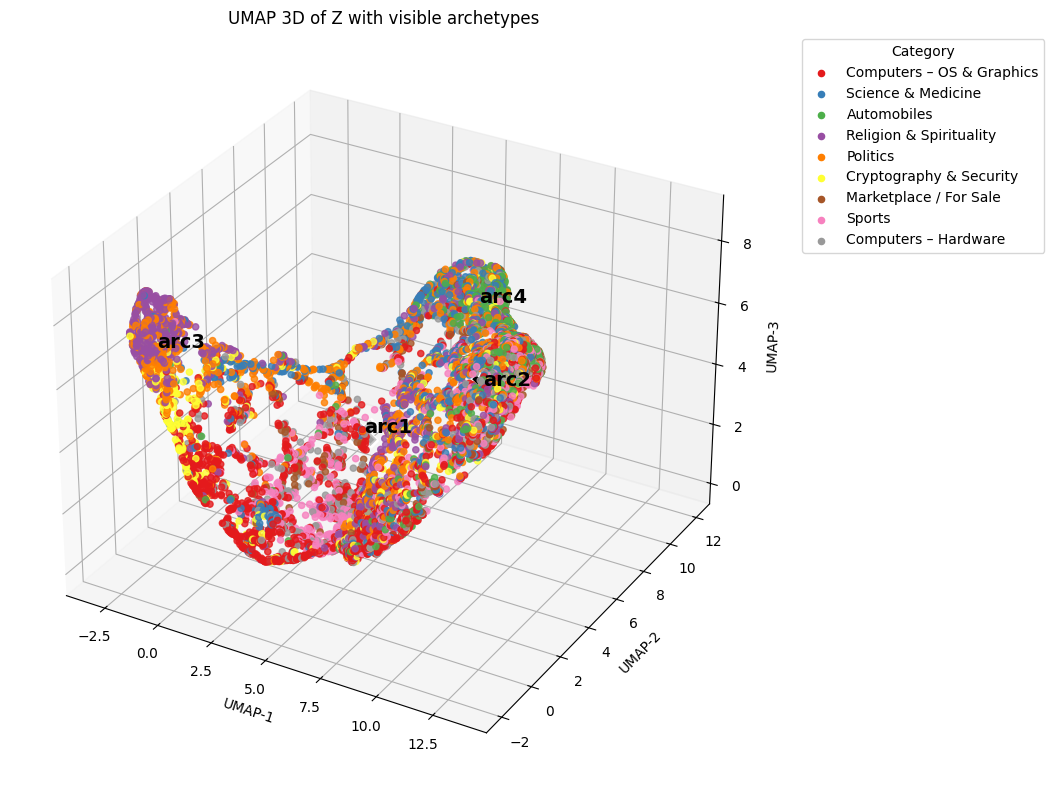

In [33]:
fig, ax = plot_umap3d_data_and_archetypes(
    model,
    categories=adata_train.obs["category"],
    palette="Set1"
)
